In [2]:
import itertools
from operator import itemgetter

import geopandas as gpd
import numpy as np
import pandas as pd

from scipy.spatial import cKDTree

import matplotlib 
import geopy.distance
import matplotlib.pyplot as plt
from math import sqrt
SPINE_COLOR = 'gray'

In [3]:
def ckdnearest(brick_kilns, rivers, gdfB_cols=['geometry']):
    A = np.vstack([np.array(geom) for geom in brick_kilns[['lon','lat']].values])
    # print(A)
    B = [np.array(geom.coords) for geom in rivers.geometry.to_list()] 
    # print(B)
    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    # print(B_ix)
    B = np.concatenate(B)
    # B = np.delete(B, 2, axis = 1) #removing z (altitude) component 
    # print(B)
    ckd_tree = cKDTree(B)
    dist, river_point_idx = ckd_tree.query(A, k=1)
    # print(dist)
    # print(river_point_idx)
    closest_river_point = B[river_point_idx]
    # print(B[river_point_idx])
    river_origin_idx = itemgetter(*river_point_idx)(B_ix)
    gdf = pd.concat(
        [brick_kilns, rivers.loc[river_origin_idx, gdfB_cols].reset_index(drop=True),
         pd.DataFrame(closest_river_point, columns = ['closest_river_point_long','closest_river_point_lat']),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

In [4]:
#https://mapcruzin.com/free-india-country-city-place-gis-shapefiles.htm#google_vignette

waterways_path = '/home/shataxi.dubey/shataxi_work/compliance_analysis/waterways/waterways.shp'
waterways = gpd.read_file(waterways_path)
# waterways[waterways['name'] == 'Ganga']['geometry']

In [5]:
fp2 = "/home/shataxi.dubey/shataxi_work/India_State_Shapefile/India_State_Shapefile/India_State_Boundary.shp"

# Read file using gpd.read_file()
data2 = gpd.read_file(fp2)

In [6]:
def cal_bk_river_dist(path):
    state_bk = pd.read_csv(path)
    # print(state_bk.columns )
    # state_bk.columns = ['lat', 'lon']
    # print(state_bk.columns )
    bk_river_mapping = ckdnearest(state_bk, waterways)
    bk_river_mapping['distance'] = 0
    # bk_river_mapping

    for i in range(len(state_bk)):
        bk_river_mapping['distance'][i] = geopy.distance.distance((bk_river_mapping['lat'][i],bk_river_mapping['lon'][i]), (bk_river_mapping['closest_river_point_lat'][i],bk_river_mapping['closest_river_point_long'][i])).km

    return bk_river_mapping

In [7]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
#              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

In [8]:
# fig_width_pt = 241.14749  # Get this from LaTeX using \the\columnwidth
fig_width_pt = 450
inches_per_pt = 1.0/72.27               # Convert pt to inches
# golden_mean = (sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
# fig_height =fig_width*golden_mean       # height in inches
# fig_height =fig_width
fig_height = 3
fig_size = [fig_width,fig_height]
fig_size

[6.226650062266501, 3]

# PUNJAB

In [114]:
bk_river_mapping = cal_bk_river_dist('/home/patel_zeel/compass24/exact_latlon/punjab.csv')
bk_river_mapping.head(2)

/tmp/ipykernel_681951/1332830719.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bk_river_mapping['distance'][i] = geopy.distance.distance((bk_river_mapping['lat'][i],bk_river_mapping['lon'][i]), (bk_river_mapping['closest_river_point_lat'][i],bk_river_mapping['closest_river_point_long'][i])).km


,parent,line_id,class,lat,lon,state,x_c,y_c,w,h,...,bottom_right_y,local_top_left_x,local_top_left_y,local_bottom_right_x,local_bottom_right_y,geometry,closest_river_point_long,closest_river_point_lat,dist,distance
0,"30.79,75.87",0,zigzag,30.788065,75.871358,punjab,2.384894e+07,1.375857e+07,0.115034,0.045408,...,1.375859e+07,622.157760,744.50432,750.995840,795.36128,"LINESTRING (76.01536 30.78311, 76.00704 30.782...",75.871653,30.77777,0.010300,1.14178
1,"30.79,75.87",1,zigzag,30.787651,75.875818,punjab,2.384935e+07,1.375861e+07,0.031660,0.100504,...,1.375867e+07,1084.514928,758.56144,1119.974352,871.12592,"LINESTRING (76.01536 30.78311, 76.00704 30.782...",75.879447,30.77943,0.008986,0.97535


textwidth & columnwidth & linewidth are 506.295pt

columnwidth & linewidth are 241.14749pt


In [115]:
latexify(fig_width, fig_height)

In [116]:
fig, ax = plt.subplots()

waterways.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'blue', linewidth = 0.2, label = 'rivers', alpha=0.8) # river data
data2.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'black', linewidth = 0.1) # Punjab map

# bk - river distance > 0.5 KM
dist_1 = bk_river_mapping[(bk_river_mapping['distance'] > 0.5)]
ax.scatter(dist_1['lon'],dist_1['lat'], color='green', s=2, marker = 'o', linewidth = 0.5, label = f'{len(dist_1)} brick kilns $>$ 0.5 Km')

# bk - river distance < 0.5 KM
dist_1 = bk_river_mapping[bk_river_mapping['distance'] <= 0.5]
ax.scatter(dist_1['lon'],dist_1['lat'], color='red', s=2, marker = 'o',linewidth = 0.5, label = f'{len(dist_1)} brick kilns $<$ 0.5 Km')

ax.text(76.1, 31.8, 'Himachal\n Pradesh')
ax.text(75.4, 30.9, 'Punjab')
ax.text(74, 29.6, 'Rajasthan')
ax.text(76, 29.6, 'Haryana')

ax.set_xlim(73.5,77)
ax.set_ylim(29.5,32.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax.set_axis_off()
format_axes(ax)
# plt.savefig('punjab_bk_river.pdf')
plt.tight_layout()
plt.savefig('punjab_bk_river.png', dpi=300)

# HARYANA

In [117]:
bk_river_mapping = cal_bk_river_dist('/home/patel_zeel/compass24/exact_latlon/haryana.csv')

/tmp/ipykernel_681951/1332830719.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bk_river_mapping['distance'][i] = geopy.distance.distance((bk_river_mapping['lat'][i],bk_river_mapping['lon'][i]), (bk_river_mapping['closest_river_point_lat'][i],bk_river_mapping['closest_river_point_long'][i])).km


In [118]:
fig, ax = plt.subplots()

waterways.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'blue', linewidth = 0.2, label = 'rivers', alpha=0.8) # river data
data2.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'black', linewidth = 0.1) # Haryana map


# bk - river distance > 0.5 KM
dist_1 = bk_river_mapping[(bk_river_mapping['distance'] > 0.5)]
ax.scatter(dist_1['lon'],dist_1['lat'], color='green', s=2, marker = 'o', linewidth = 0.5, label = f'{len(dist_1)} brick kilns $>$ 0.5 Km')

# bk - river distance < 0.5 KM
dist_1 = bk_river_mapping[bk_river_mapping['distance'] <= 0.5]
ax.scatter(dist_1['lon'],dist_1['lat'], color='red', s=2, marker = 'o',linewidth = 0.5, label = f'{len(dist_1)} brick kilns $<$ 0.5 Km')

ax.text(77.3, 29.5, 'Uttar\n Pradesh')
ax.text(74.5, 28.5, 'Rajasthan')
ax.text(75.5, 30.5, 'Punjab')
ax.text(75.8, 28.5, 'Haryana')
ax.text(77, 28.6, 'New Delhi')

ax.set_xlim(74,78)
ax.set_ylim(27.5,31)
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
format_axes(ax)
ax.set_axis_off()
plt.tight_layout()
plt.savefig('haryana_bk_river.pdf')
plt.savefig('haryana_bk_river.png', dpi=300)


# BIHAR

In [ ]:
bk_river_mapping = cal_bk_river_dist('/home/shahshrimay/compliance/bihar_labels_tp.csv')

In [ ]:
fig, ax = plt.subplots()

waterways.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'blue', linewidth = 0.3, label = 'rivers') # river data
data2.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'black', linewidth = 0.1) # Bihar map


# bk - river distance > 0.5 KM
dist_1 = bk_river_mapping[(bk_river_mapping['distance'] > 0.5)]
ax.scatter(dist_1['lon'],dist_1['lat'], color='green', s=2, marker = 'o', linewidth = 0.5, label = f'{len(dist_1)} brick kilns $>$ 0.5 Km')

# bk - river distance < 0.5 KM
dist_1 = bk_river_mapping[bk_river_mapping['distance'] <= 0.5]
ax.scatter(dist_1['lon'],dist_1['lat'], color='red', s=2, marker = 'o',linewidth = 0.5, label = f'{len(dist_1)} brick kilns $<$ 0.5 Km')

ax.text(83.2, 25.8, 'Uttar Pradesh')
ax.text(85.6, 24.3, 'Jharkhand')
ax.text(86, 26.3, 'Bihar' )
ax.text(88, 25.3, 'West Bengal')

ax.set_xlim(83,89)
ax.set_ylim(24.25,27.6)
plt.legend(loc = 'upper center')
format_axes(ax)
ax.set_axis_off()
# plt.savefig('bihar_bk_river.pdf')
# plt.savefig('bihar_bk_river.png')

BRICK KILN HOSPITAL DISTANCE

In [12]:
hospital_df = pd.read_csv('/home/rishabh.mondal/bkdb/India_Hospital_Data.csv')
hospital_df = hospital_df.rename(columns = {'lon' : 'lon', 'lat' : 'lat'})

In [13]:
def ckdnearest_hospital(brick_kilns, hospital_df):
    A = np.vstack([np.array(geom) for geom in brick_kilns[['lon','lat']].values])
    B = np.vstack([np.array(geom) for geom in hospital_df[['lon','lat']].values] )
    ckd_tree = cKDTree(B)
    dist, hospital_idx = ckd_tree.query(A, k=1)
    closest_hospital_point = B[hospital_idx]
    gdf = pd.concat(
        [brick_kilns,
         pd.DataFrame(closest_hospital_point, columns = ['closest_hospital_long','closest_hospital_lat']),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

In [14]:
def cal_bk_hosp_dist(path):
    state_bk =pd.read_csv(path)
    bk_hospital_mapping = ckdnearest_hospital(state_bk, hospital_df)
    # print(bk_hospital_mapping)
    bk_hospital_mapping['distance_km'] = 0

    for i in range(len(bk_hospital_mapping)):
        bk_hospital_mapping['distance_km'][i] = geopy.distance.distance((bk_hospital_mapping['lat'][i],bk_hospital_mapping['lon'][i]), (bk_hospital_mapping['closest_hospital_lat'][i],bk_hospital_mapping['closest_hospital_long'][i])).km

    return bk_hospital_mapping

PUNJAB

In [40]:
bk_hospital_mapping = cal_bk_hosp_dist('/home/patel_zeel/compass24/exact_latlon/punjab.csv')
bk_hospital_mapping.head(2)

/tmp/ipykernel_765757/1286038133.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bk_hospital_mapping['distance_km'][i] = geopy.distance.distance((bk_hospital_mapping['lat'][i],bk_hospital_mapping['lon'][i]), (bk_hospital_mapping['closest_hospital_lat'][i],bk_hospital_mapping['closest_hospital_long'][i])).km


,parent,line_id,class,lat,lon,state,x_c,y_c,w,h,...,bottom_right_x,bottom_right_y,local_top_left_x,local_top_left_y,local_bottom_right_x,local_bottom_right_y,closest_hospital_long,closest_hospital_lat,dist,distance_km
0,"30.79,75.87",0,zigzag,30.788065,75.871358,punjab,2.384894e+07,1.375857e+07,0.115034,0.045408,...,2.384900e+07,1.375859e+07,622.157760,744.50432,750.995840,795.36128,75.883065,30.801756,0.018013,1.886587
1,"30.79,75.87",1,zigzag,30.787651,75.875818,punjab,2.384935e+07,1.375861e+07,0.031660,0.100504,...,2.384937e+07,1.375867e+07,1084.514928,758.56144,1119.974352,871.12592,75.883065,30.801756,0.015858,1.710660


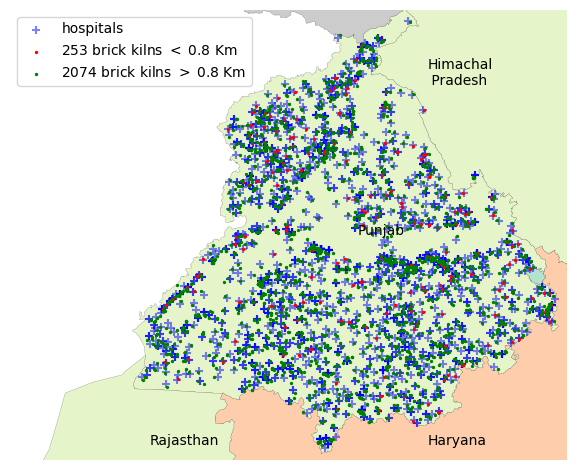

In [49]:
fig, ax = plt.subplots()

vulnerable_hospital = bk_hospital_mapping[bk_hospital_mapping['distance_km'] <= 0.8]
non_vulnerable_hospital = bk_hospital_mapping[bk_hospital_mapping['distance_km'] > 0.8]
data2.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'black', linewidth = 0.1) # Punjab map
ax.scatter(bk_hospital_mapping['closest_hospital_long'], bk_hospital_mapping['closest_hospital_lat'],color = 'blue', marker='+', label = f'hospitals', alpha=0.5) # hospital data
# ax.scatter(non_vulnerable_hospital['closest_hospital_long'], non_vulnerable_hospital['closest_hospital_lat'],color = 'blue', marker='+', label = f'{len(non_vulnerable_hospital)} hospitals $>$ 0.8 Km') # hospital data

ax.scatter(vulnerable_hospital['lon'], vulnerable_hospital['lat'], color = 'red', s=2, label = f'{len(vulnerable_hospital)} brick kilns $<$ 0.8 Km') # hospital data
ax.scatter(non_vulnerable_hospital['lon'], non_vulnerable_hospital['lat'], color = 'green', s=2, label = f'{len(non_vulnerable_hospital)} brick kilns $>$ 0.8 Km') # hospital data

ax.text(76, 32, 'Himachal\n Pradesh')
ax.text(75.5, 31, 'Punjab')
ax.text(74, 29.6, 'Rajasthan')
ax.text(76, 29.6, 'Haryana')

ax.set_xlim(73,77)
ax.set_ylim(29.5,32.5)
plt.legend(loc='upper left')
ax.set_axis_off()
plt.tight_layout()
plt.savefig('punjab_bk_hosp.pdf')
plt.savefig('punjab_bk_hosp.png', dpi=300)

HARYANA

/tmp/ipykernel_765757/1286038133.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bk_hospital_mapping['distance_km'][i] = geopy.distance.distance((bk_hospital_mapping['lat'][i],bk_hospital_mapping['lon'][i]), (bk_hospital_mapping['closest_hospital_lat'][i],bk_hospital_mapping['closest_hospital_long'][i])).km


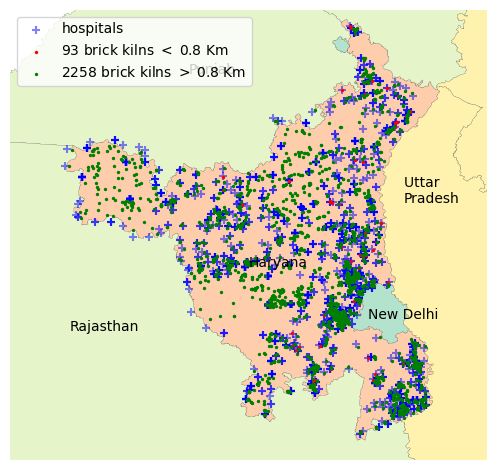

In [50]:
bk_hospital_mapping = cal_bk_hosp_dist('/home/patel_zeel/compass24/exact_latlon/haryana.csv')

vulnerable_hospital = bk_hospital_mapping[bk_hospital_mapping['distance_km'] <= 0.8]
non_vulnerable_hospital = bk_hospital_mapping[bk_hospital_mapping['distance_km'] > 0.8]

fig, ax = plt.subplots()

data2.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'black', linewidth = 0.1) # Haryana map
ax.scatter(bk_hospital_mapping['closest_hospital_long'], bk_hospital_mapping['closest_hospital_lat'],color = 'blue', marker='+', label = f'hospitals', alpha=0.5) # hospital data

ax.scatter(vulnerable_hospital['lon'], vulnerable_hospital['lat'], color = 'red', s=2, label = f'{len(vulnerable_hospital)} brick kilns $<$ 0.8 Km') # hospital data
ax.scatter(non_vulnerable_hospital['lon'], non_vulnerable_hospital['lat'], color = 'green', s=2, label = f'{len(non_vulnerable_hospital)} brick kilns $>$ 0.8 Km') # hospital data

ax.text(77.3, 29.5, 'Uttar \nPradesh')
ax.text(74.5, 28.5, 'Rajasthan')
ax.text(75.5, 30.5, 'Punjab')
ax.text(76, 29, 'Haryana')
ax.text(77, 28.6, 'New Delhi')

ax.set_xlim(74,78)
ax.set_ylim(27.5,31)
plt.legend()
ax.set_axis_off()
plt.tight_layout()
plt.savefig('haryana_bk_hosp.pdf')
plt.savefig('haryana_bk_hosp.png', dpi=300)

Bihar

In [ ]:
bk_hospital_mapping = cal_bk_hosp_dist('/home/shahshrimay/compliance/bihar_labels_tp.csv')

vulnerable_hospital = bk_hospital_mapping[bk_hospital_mapping['distance_km'] <= 0.8]
non_vulnerable_hospital = bk_hospital_mapping[bk_hospital_mapping['distance_km'] > 0.8]


fig, ax = plt.subplots()

data2.plot(ax=ax, cmap = 'Pastel2', edgecolor = 'black', linewidth = 0.1) # Bihar map
ax.scatter(vulnerable_hospital['closest_hospital_long'], vulnerable_hospital['closest_hospital_lat'],color = 'red', marker='+', label = f'{len(vulnerable_hospital)} hospitals $<=$ 0.88 Km') # hospital data
ax.scatter(non_vulnerable_hospital['closest_hospital_long'], non_vulnerable_hospital['closest_hospital_lat'],color = 'blue', marker='+', label = f'{len(non_vulnerable_hospital)} hospitals $>$ 0.88 Km') # hospital data
ax.scatter(vulnerable_hospital['lon'], vulnerable_hospital['lat'],color = 'black', marker='.', label = 'Brick kilns') # brick kilns

ax.text(83.2, 25.8, 'Uttar\n Pradesh')
ax.text(85.6, 24.3, 'Jharkhand')
ax.text(86, 26.3, 'Bihar' )
ax.text(88, 25.3, 'West\n Bengal')

ax.set_xlim(83,89)
ax.set_ylim(24.25,27.6)
plt.legend(loc = 'upper center')
ax.set_axis_off()
# plt.savefig('bihar_bk_hosp.pdf')
# plt.savefig('bihar_bk_hosp.png')